# Assigment 3: CAMSHIFT
## Paper
Read the paper "Bradski_etal_1998_camshift.pdf" in KVV (under "Resources/papers"). 

## Calculate histogram
* Implement a function that creates a color histogram. Pass either an image and ROI, or the image underlying the ROI. 
* For this purpose, a second (or third) parameter can be passed to specify the number of bins. 
* Load the image "images/racecar.png" and convert the image to the HSV color space. Plot the Hue channel. (**RESULT**)

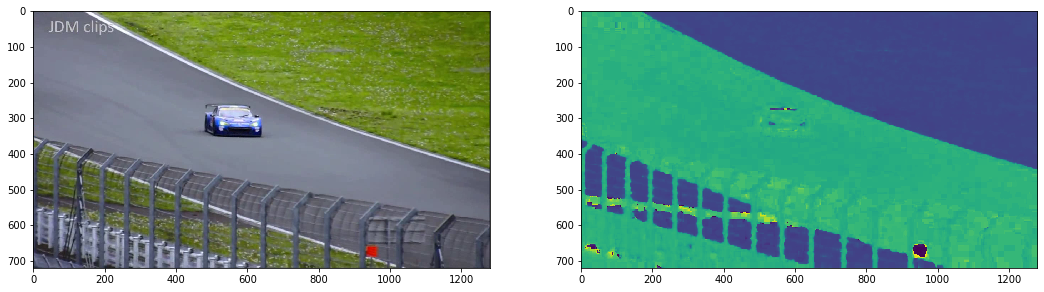

In [16]:
# dieser Code wurde als Musterlösung von Tobias Schülke zur Verfügung gestellt und von Tim renoviert

%matplotlib inline 
from skimage import io, color
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import os
import warnings; warnings.simplefilter('ignore')


IMAGES_PER_ROW = 4

MIN_SATURATION_CAR = 0.2
MIN_VALUE_CAR = 0.5
MIN_SATURATION_TACO = 0.8
MIN_VALUE_TACO = 0.2

ROI_FRAME_MARGIN_CAR = 60
ROI_FRAME_MARGIN_TACO = 20


def create_color_histogram(img, bins=360, normalize=False):
    hues = color.rgb2hsv(img)[:, :, 0]
    hist, bin_edges = np.histogram(hues, bins=bins, range=(0, 1))
    if normalize:
        hist = hist / np.max(hist)
    return hist, bin_edges

def plot_histogram(ax, hist, bins=360):
    X = range(0, bins)
    hsv_colors = np.array([[h/bins, 1, 1] for h in X])
    rgb_colors = (
        color.hsv2rgb(
            # reshape to make 'hsv2rgb' work because it expects an image
            hsv_colors.reshape((bins, 1, 3))
        )
        .reshape((bins, 3))
    )
    return ax.bar(X, hist, color=rgb_colors)

def create_and_plot_histogram(ax, img, bins=360):
    hist, bin_edges = create_color_histogram(img, bins=bins)
    return hist, bin_edges, plot_histogram(ax, hist, bins=bins)


image = io.imread('images/racecar.png')

fig = plt.figure(figsize=(18, 12))
ax1 = plt.subplot(2, 2, 1)
ax2 = plt.subplot(2, 2, 2)

ax1.imshow(image)
ax2.imshow(color.rgb2hsv(image)[:, :, 0])

None

* display the histogram for the Hue channel for the entire image and for the RIO (x,y) = (480, 260) to (640, 350). Vary the number of bins for testing purposes (**RESULT**).

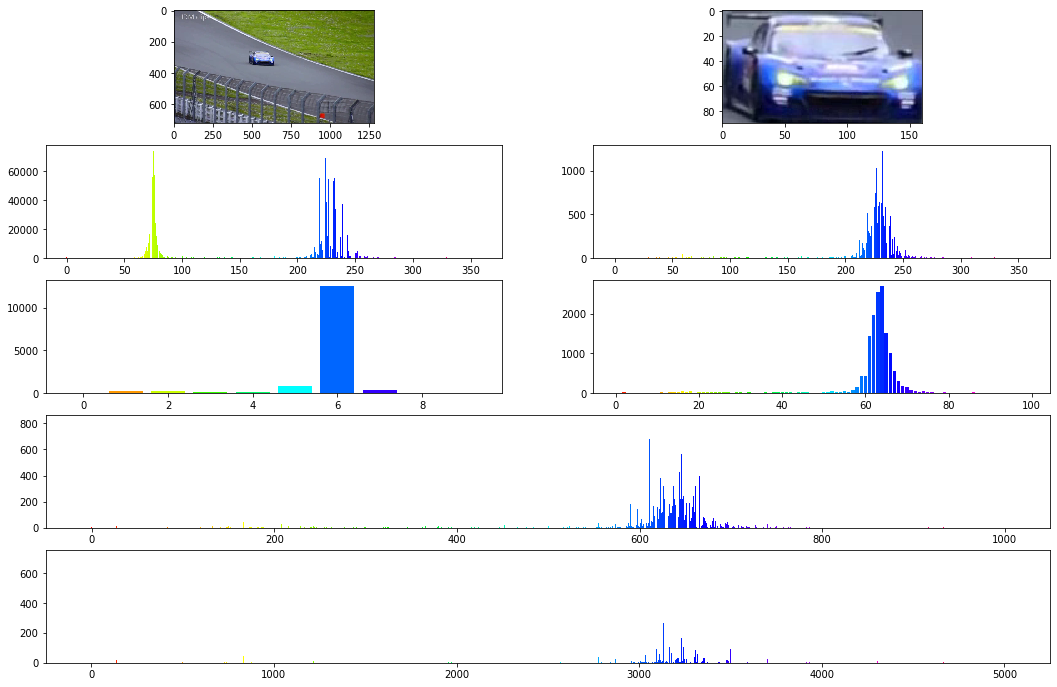

In [17]:
image_car = image[260:350, 480:640]

fig = plt.figure(figsize=(18, 12))
grid = fig.add_gridspec(5, 2)
ax1 = fig.add_subplot(grid[0, 0])
ax2 = fig.add_subplot(grid[0, 1])
ax3 = fig.add_subplot(grid[1, 0])
ax4 = fig.add_subplot(grid[1, 1])
ax5 = fig.add_subplot(grid[2, 0])
ax6 = fig.add_subplot(grid[2, 1])
ax7 = fig.add_subplot(grid[3, :])
ax8 = fig.add_subplot(grid[4, :])

ax1.imshow(image)
ax2.imshow(image_car)
create_and_plot_histogram(ax3, image)
create_and_plot_histogram(ax4, image_car)
create_and_plot_histogram(ax5, image_car, bins=10)
create_and_plot_histogram(ax6, image_car, bins=100)
create_and_plot_histogram(ax7, image_car, bins=1000)
create_and_plot_histogram(ax8, image_car, bins=5000)

None

## probability distribution
* implement the method outlined in the CAMSHIFT paper to create a probability distribution for a given object's hue histogram
* create the histogram of the car from the image "racecar.png" and apply the new function to the last frame of the video (images/racecar/151.jpg) (**RESULT**)


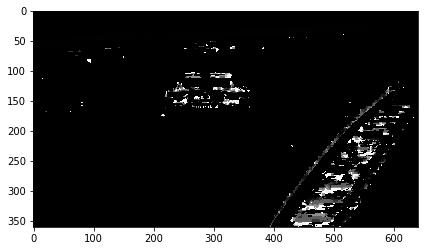

In [117]:
# Tip: in der Nacht sind alle Katzen grau ;)
def create_prob_distribution(img, hist, bin_edges, min_saturation, min_value):
    img_hsv = color.rgb2hsv(img)
    # We want grayscale.
    prob_dist = np.zeros((img.shape[0], img.shape[1]))
#     print('hsv', img_hsv.shape)
    # Ignore irrelevant pixels (see page 3 in the paper).
    indices = np.logical_and(img_hsv[:, :, 1] >= min_saturation, img_hsv[:, :, 2] >= min_value)
#     print('indices', indices.shape)
    hues = img_hsv[indices, 0]
#     print('hues', hues.shape)
    binned_hues = np.digitize(hues, bin_edges)
#     print('>', binned_hues.shape)
    max_index = len(bin_edges) - 1
    binned_hues[np.where(binned_hues == max_index)] -= 1
    prob_dist[indices] = hist[binned_hues]
    return prob_dist


last_frame = io.imread('images/racecar/151.jpeg')
histogram_car, bin_edges = create_color_histogram(image_car, bins=100, normalize=True)
prob_dist = create_prob_distribution(last_frame, histogram_car, bin_edges, MIN_SATURATION_CAR, MIN_VALUE_CAR)
io.imshow(prob_dist)

None

### show ROI in image


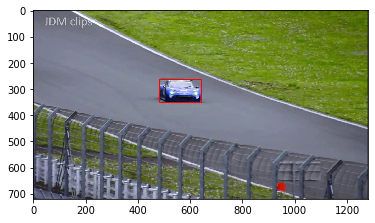

In [19]:
def draw_roi(image, x, y, width, height, out=plt):
    ax = plt.gca()
    ax.add_patch(
        patches.Rectangle(
            (x, y),
            width,
            height,
            fill=False,
            edgecolor="red"
        )
    )
    
    out.imshow(image)

draw_roi(image, 480, 260, 160, 90)

## Exercise 3.2 - Mean Shift
* Implement the Mean Shift method for a ROI as described in the lecture. Test the algorithm on the image sequences "images/racecar/*.jpg" or "images/taco/*.jpg". Select the appropriate tracking window (to reduce the file size I have reduced the images by a factor of 2, i.e. the ROI from above must be adjusted accordingly). 
* Draw the trajectory of the objects as returned by Mean Shift. (**RESULT**)

M_00 == 0, i = 89
M_00 == 0, i = 90
M_00 == 0, i = 92


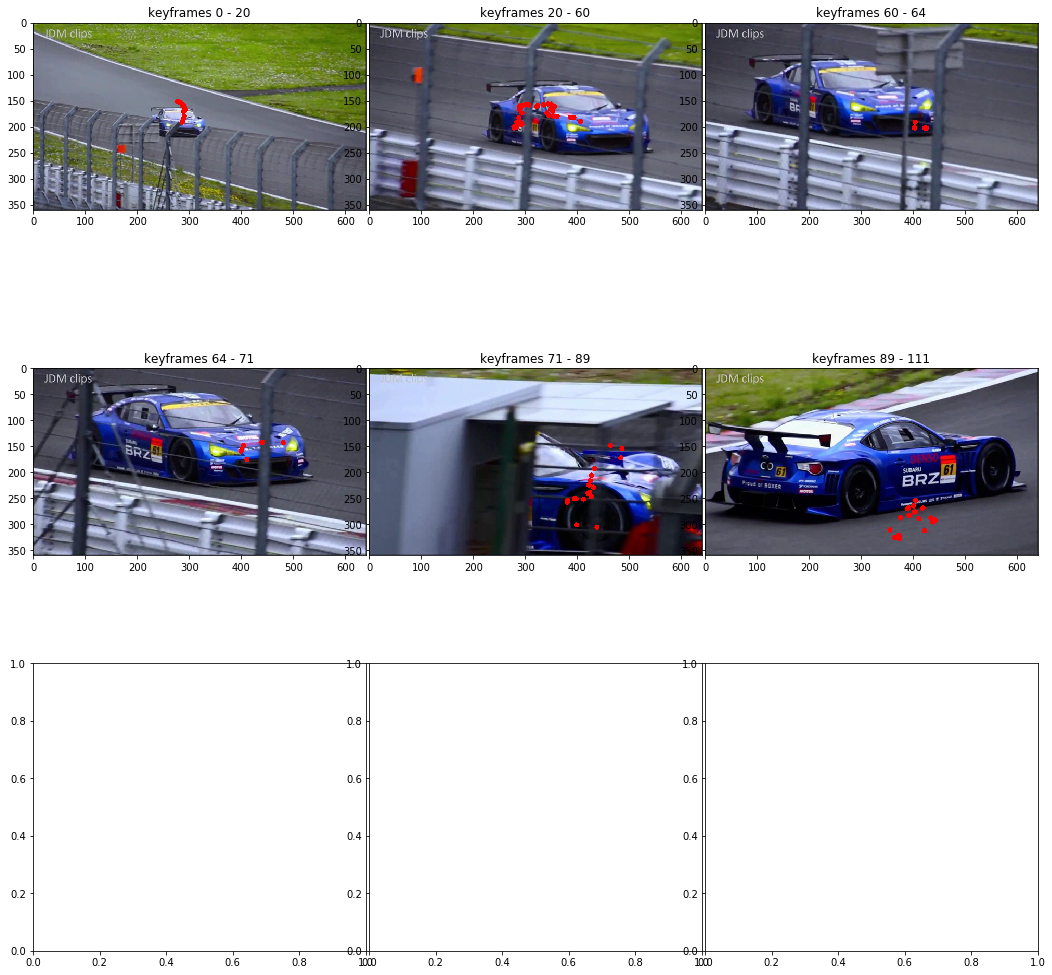

In [190]:
from math import ceil

from numpy.linalg import norm
from skimage.draw import circle


def camshift():
    pass


def get_center(rect):
    return np.mean(rect.T, axis=1).round()


def get_diag_len(rect):
    top_left, bottom_right = rect
    return np.sqrt(np.square(top_left[0] - bottom_right[0]) + np.square(top_left[1] - bottom_right[1]))


def get_roi(img, rect):
    top_left, bottom_right = rect
    return img[top_left[0]:bottom_right[0], top_left[1]:bottom_right[1]]


def mean_shift(initial_window, frames, create_prop_dist, *, 
               frame_indices_to_draw=None,
               keyframes=None,
               shift_threshold=4, max_iterations=5):
    first_frame, frames = frames[0], frames[1:]

    if frame_indices_to_draw is None:
        frame_indices_to_draw = range(len(frames))
    if keyframes is None:
        keyframes = []

    window = initial_window
    centroids = [get_center(window)]

    NCOLS = 3
    fig, axes = plt.subplots(
        nrows=ceil((len(frame_indices_to_draw) + len(keyframes)) / NCOLS),
        ncols=NCOLS,
    )
    fig.set_figheight(18)
    fig.set_figwidth(18)
    plt.subplots_adjust(wspace = .01)
#     fig.tight_layout()
    axes = np.asarray(axes).ravel()

    i = -1
    plot_index = 0
    for frame in frames:
#         print('i =', i)
        i += 1
        prev_centroid = centroids[-1]
        temp_centroids = [prev_centroid]
        
        num_iterations = -1
        while True:
            num_iterations += 1
            
            roi = get_roi(frame, window)
            hist, bin_edges = create_color_histogram(roi, bins=100, normalize=True)
            prop_dist = create_prop_dist(roi, hist, bin_edges)
#             print(prop_dist.tolist())
            
            moments = M_00, _ = get_moments(prop_dist)
            if M_00 == 0:
                print('M_00 == 0, i =', i)
                break
        
            centroid = window[0] + get_centroid(moments)
            temp_centroids.append(centroid)
            
            v = centroid - prev_centroid
            prev_centroid = centroid
#             # length = norm(v)
#             length = np.sqrt(v.dot(v))
#             print(length, length is np.nan)
#             # Some kind of overflow has occured because the 2 centroids are very close together.
#             if length is np.nan or length > get_diag_len(window):
#                 print('!!!!!!!!!!!!!!!!!!!!!!!!!')
#                 break
            window += v.round().astype(np.int)
#             print('dist', norm(v), '|', v)
            if norm(v) <= shift_threshold or num_iterations > max_iterations:
                break

        centroids.append(centroid)
        if i in frame_indices_to_draw:
            axes[plot_index].imshow(draw_centroids(frame, temp_centroids))
            plot_index += 1
#             ax = fig.add_subplot(ceil(plot_index / NCOLS), NCOLS, plot_index)
#             plot_index += 1
#             ax.imshow(draw_centroids(frame, temp_centroids))
        if i in keyframes:
            j = keyframes.index(i)
            start = keyframes[j - 1] if j > 0 else 0
            c = centroids[start:keyframes[j]]
            axes[plot_index].imshow(draw_centroids(frame, c))
            axes[plot_index].set_title(f'keyframes {start} - {keyframes[j]}')
            plot_index += 1
            
    return centroids


def get_moments(prop_dist):
    """Returns 0th and 1st image moments."""
    M_00 = np.sum(prop_dist)
    # Because we only have positive values (propabilities) 
    # we know that all values must be zero, thus:
    # M_00 == Σx Σy I(x,y) == 0  =>  Σx Σy x*I(x,y) == M_10 == 0
    if M_00 > 0:
        num_rows, num_cols = prop_dist.shape
        x_indices = np.arange(0, num_cols)
        y_indices = np.arange(0, num_rows)
        M_10 = np.sum(prop_dist[:] * x_indices)
        M_01 = np.sum(prop_dist.T[:] * y_indices)
    else:
        M_10 = M_01 = 0
    return (M_00, (M_10, M_01))


def get_centroid(moments, row_first=True):
    M_00, (M_10, M_01) = moments
    centroid = np.array([M_01, M_10])
    if M_00 > 0:
        centroid = centroid / M_00
    # print(centroid)
    if row_first:
        return centroid
    return np.flip(centroid)


def draw_centroids(img, centroids):
    img = np.copy(img)
    for centroid in centroids:
        rr, cc = circle(*centroid, radius=5, shape=img.shape)
        img[rr, cc] = [255, 0, 0]
    return img


frames = io.imread_collection('images/racecar/*')
initial_window = np.array([[130, 237], [175, 316]])

centroids = mean_shift(
    initial_window, 
    frames, 
    lambda img, hist, bin_edges: 
        create_prob_distribution(img, hist, bin_edges, MIN_SATURATION_CAR, MIN_VALUE_CAR),
    frame_indices_to_draw=[],
    keyframes=[20, 60, 64, 71, 89, 111, 150],
)

None

##  Exercise 3.3 - CAMSHIFT
* extend your algorithm by adjusting the size of the ROI and finding the object's orientation
* execute the algorithm again on one of the image sequences and draw an ellipse on the image, which represents the found parameters (**RESULT**)